In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
import sys
Scripts_Folder = '/home/sheffieldlab/Desktop/NoReward/Scripts/BayesDecoder/'
sys.path.append(Scripts_Folder)

from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [31]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR21/'
animalname = os.path.basename(os.path.normpath(FolderName))
frame_lick_stop = 5154
task_numframes = {'Task1': 15000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task4 is 120
Number of PlaceCells in Task2 is 106
Number of PlaceCells in Task3 is 129
Number of PlaceCells in Task1 is 99


### Load required Data - load actual running data

#### Control Data

In [7]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

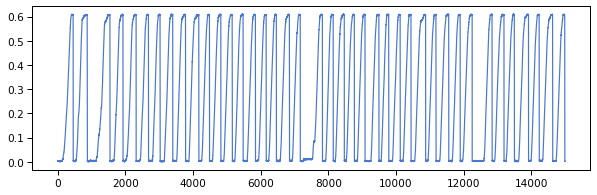

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [9]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

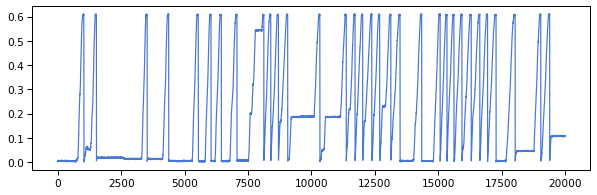

In [10]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

### Compare velocity of tasks and select laps with comparable speeds

Chosen speeds
Number of chosen laps : Task1 : 33, Task2 : 20
Remainin laps in 7
Task1 [ 8.00516462  9.81278244 10.65203357  6.74628793  8.52162686  5.93931569
  7.23047127  6.68173015  7.48870239  6.68173015  7.39186572  7.39186572
  6.00387347  6.00387347  6.13298903  7.55326017  7.58553906  8.00516462
  6.00387347  6.55261459  6.48805681  6.8431246   6.06843125  8.42479019
  7.35958683  7.90832795  7.1336346   8.10200129  6.74628793  7.84377017
  5.9070368   8.94125242  6.32666236]
Task2 [ 6.13298903  6.16526791  7.26275016  8.10200129  7.84377017 10.03873467
 10.32924467  7.94060684  8.52162686  8.42479019  7.7792124   6.90768238
  7.90832795  8.0697224  10.74887024  9.39315688  8.55390575  9.07036798
  9.6191091   8.74757908]
Worst lap speeds Task2
[18.39896708 38.25048418 31.14912847 11.10393802 12.26597805 11.26533247
 30.72950291]


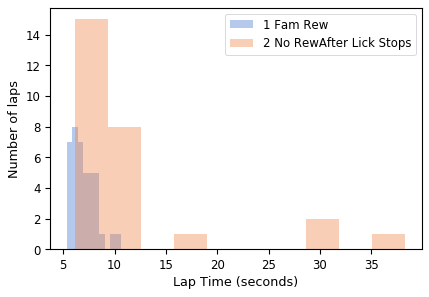

In [11]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_velocity_distribution(A, [TaskA, TaskB])
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0.3, after_stoplick=1)

In [12]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 20]])

Data shapes :  (8378, 304) (8378, 1)
[ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 17 19 21 22 23 24 26 27 28 30
 32 33 34 35 36 37 38 39]
[ 3 34  2 11 15  7 26 21 35 22 27 13 39 14 23  1 38  8 32 36]
New data shapes :  (5057, 304) (5057, 1)


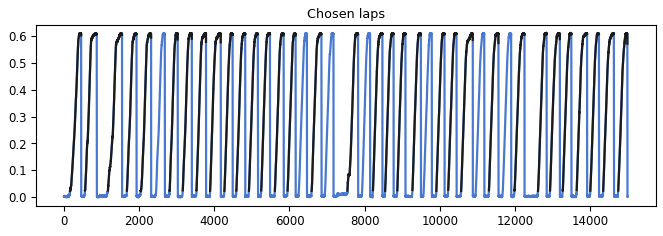

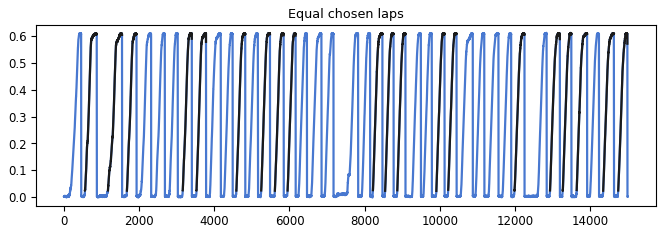

In [13]:
#Equalize laps between tasks
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (5905, 304) (5905, 1)


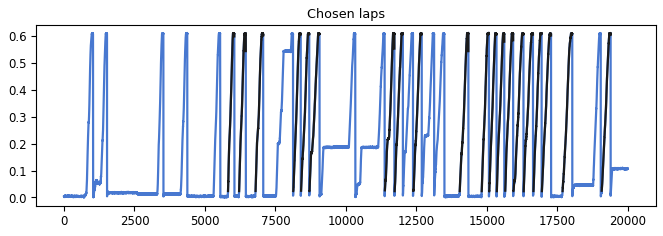

In [14]:
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=1, figureflag=1)

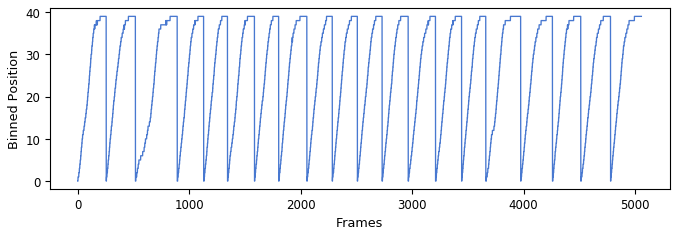

In [15]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_v_eq, tracklength=tracklength, trackbins=trackbins)
y_v_eq_cat = B.position_binary

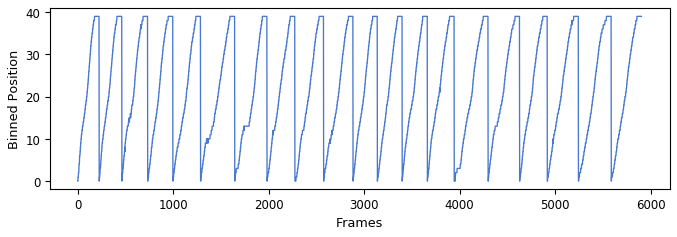

In [16]:
B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength, trackbins=trackbins)
y_v_cat_norew = B.position_binary

### Run Naive Bayes on chosen lap data

#### Control data

Data shapes :  (4045, 304) (1012, 304) (4045,) (1012,)

Accuracy of test set:: 0.42%


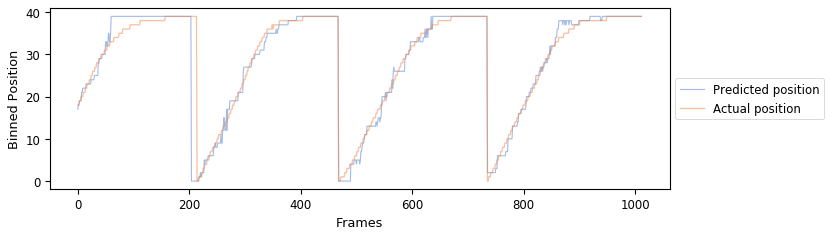

R2: 0.88
rho: 0.95




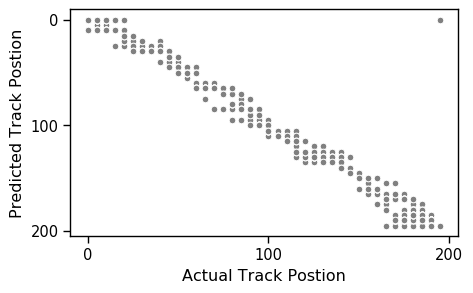

In [17]:
y_test, y_predicted = rnb.run_naivebayes(X_v_eq, y_v_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)

#### No reward Data

Data shapes :  (4724, 304) (1181, 304) (4724,) (1181,)

Accuracy of test set:: 0.25%


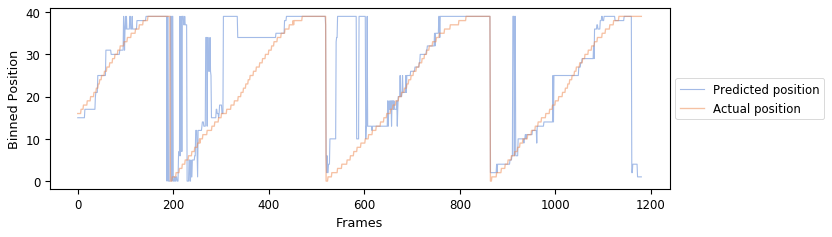

R2: 0.18
rho: 0.62




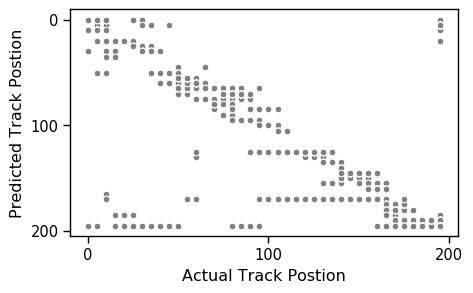

R2: 0.18
rho: 0.62




In [18]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_norew, y_v_cat_norew, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

### K-fold validation of tasks

In [19]:
nsplits = 5

#### Control Data

Performing 5-fold validation
Validation 1
(4045, 304) (4045,) (1012, 304) (1012,)

Accuracy of test set:: 0.28%


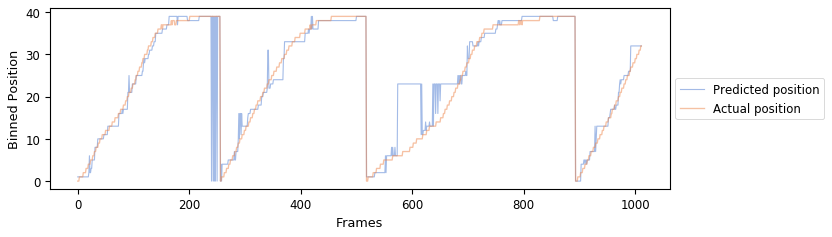

Validation 2
(4045, 304) (4045,) (1012, 304) (1012,)

Accuracy of test set:: 0.43%


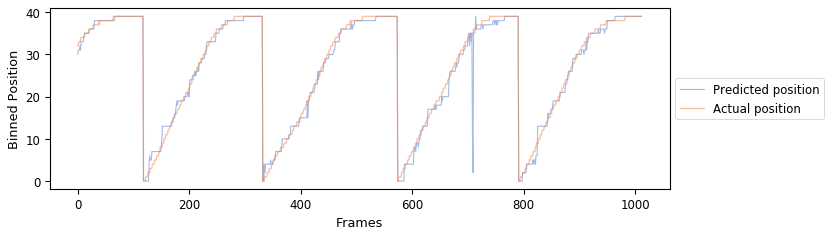

Validation 3
(4046, 304) (4046,) (1011, 304) (1011,)

Accuracy of test set:: 0.39%


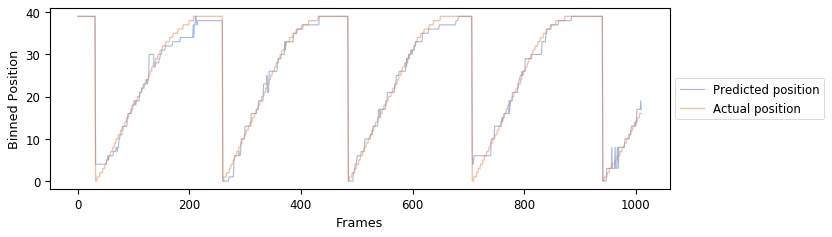

Validation 4
(4046, 304) (4046,) (1011, 304) (1011,)

Accuracy of test set:: 0.42%


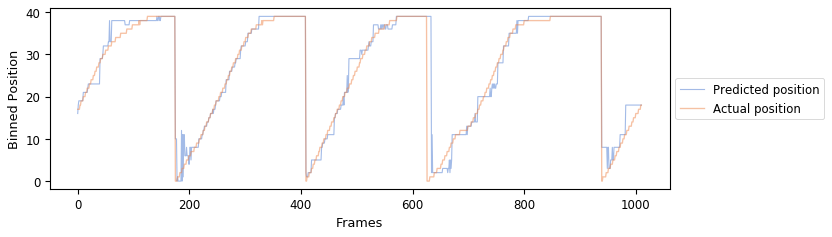

Validation 5
(4046, 304) (4046,) (1011, 304) (1011,)

Accuracy of test set:: 0.42%


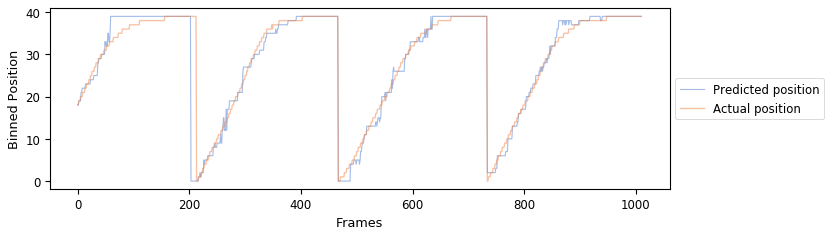

In [20]:
controlcv_dataframe = rnb.k_foldvalidation(X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=1)

Performing 5-fold validation
Validation 1
(4724, 304) (4724,) (1181, 304) (1181,)

Accuracy of test set:: 0.21%


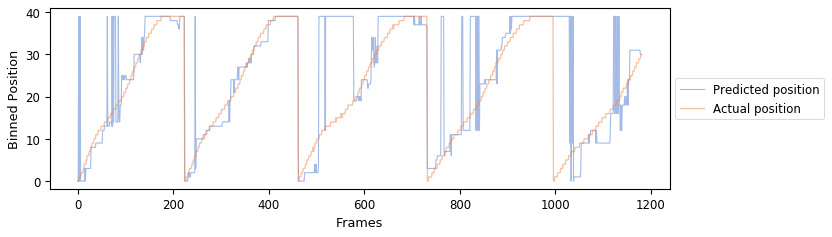

Validation 2
(4724, 304) (4724,) (1181, 304) (1181,)

Accuracy of test set:: 0.21%


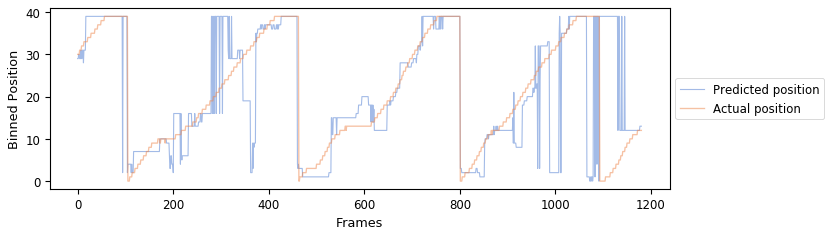

Validation 3
(4724, 304) (4724,) (1181, 304) (1181,)

Accuracy of test set:: 0.30%


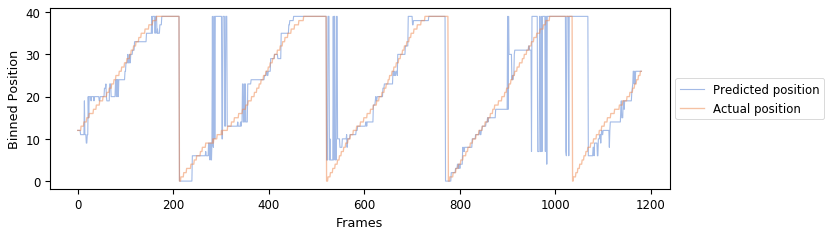

Validation 4
(4724, 304) (4724,) (1181, 304) (1181,)

Accuracy of test set:: 0.23%


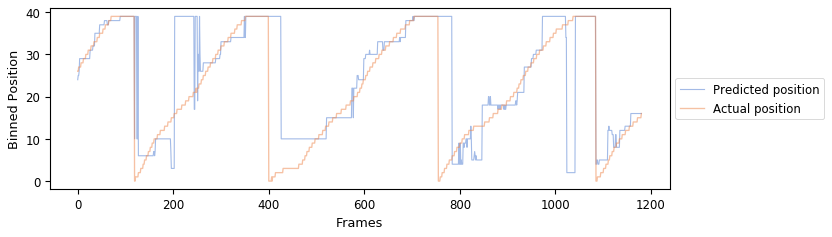

Validation 5
(4724, 304) (4724,) (1181, 304) (1181,)

Accuracy of test set:: 0.25%


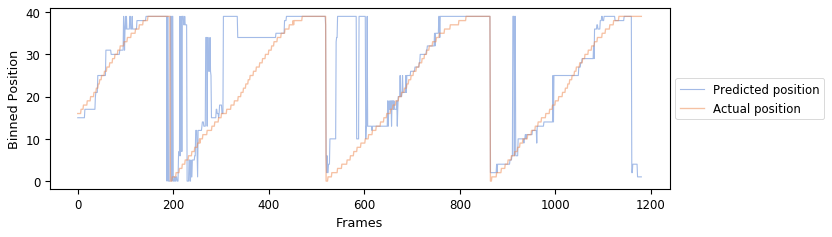

In [21]:
norewardcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=1)

### Compare Control with the worst but corrected laps

In [22]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

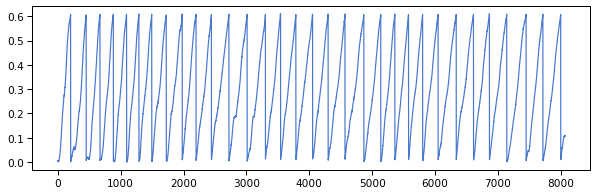

In [23]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

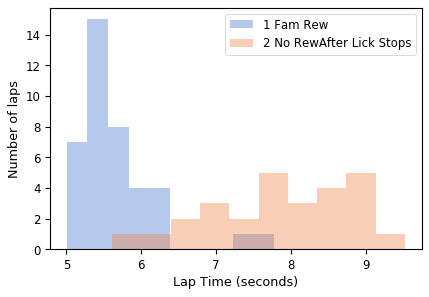

In [24]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_corrected_velocity_distribution(A, [TaskA, TaskB])

In [25]:
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Data shapes :  (1843, 304) (1843, 1)
[30 12 18 13  8 19 16]
[30 12 18 13  8 19 16]
New data shapes :  (1843, 304) (1843, 1)


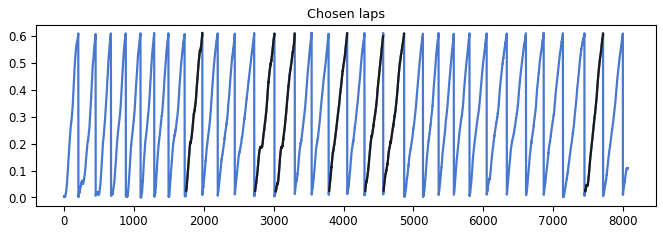

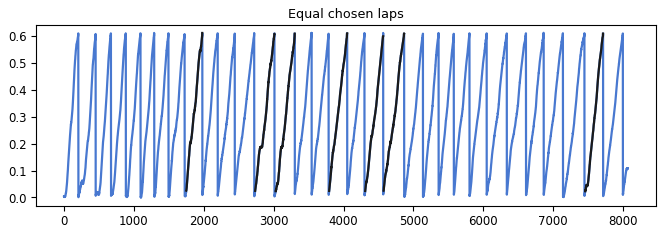

In [26]:
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)
X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1, lapcorrectionflag=1)

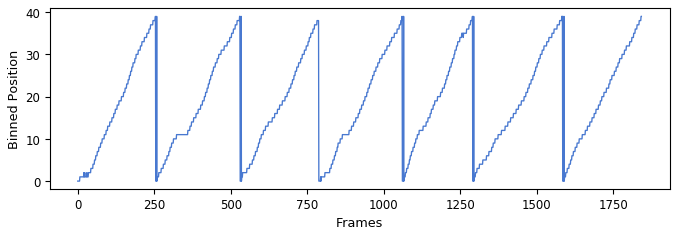

In [27]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength, trackbins=trackbins, trackstart_index=1)
y_norew_goodlaps_eq_cat = B.position_binary

#### Run Bayes classifier on the corrected worst laps

Data shapes :  (1474, 304) (369, 304) (1474,) (369,)

Accuracy of test set:: 0.10%


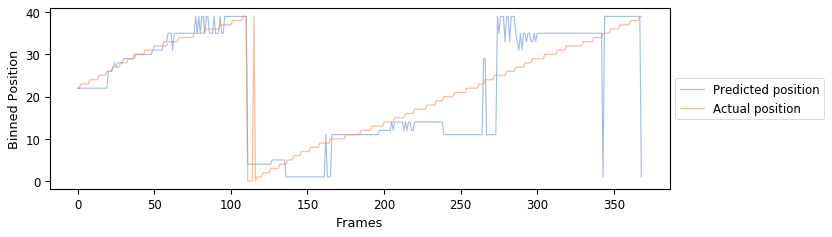

R2: 0.70
rho: 0.90




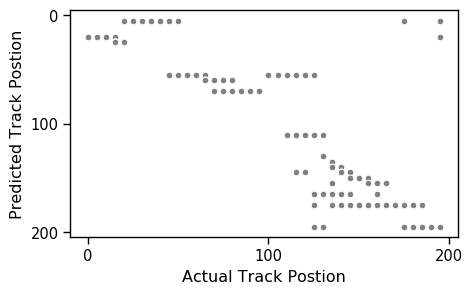

R2: 0.70
rho: 0.90




In [28]:
y_test, y_predicted = rnb.run_naivebayes(X_norew_goodlaps_eq, y_norew_goodlaps_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(1474, 304) (1474,) (369, 304) (369,)

Accuracy of test set:: 0.10%


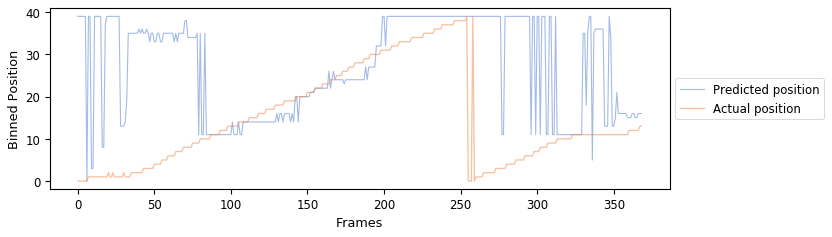

Validation 2
(1474, 304) (1474,) (369, 304) (369,)

Accuracy of test set:: 0.09%


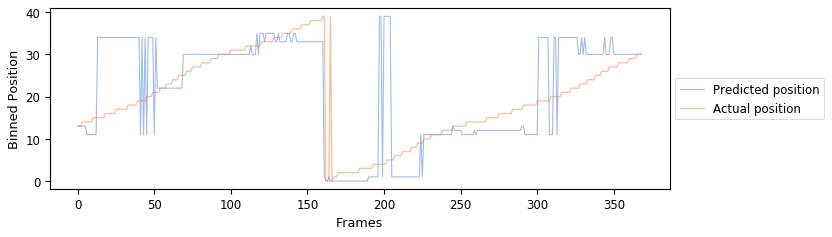

Validation 3
(1474, 304) (1474,) (369, 304) (369,)

Accuracy of test set:: 0.14%


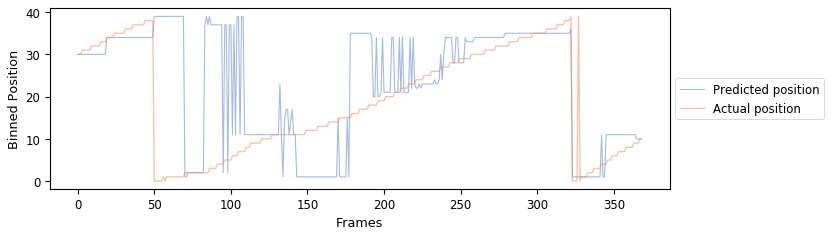

Validation 4
(1475, 304) (1475,) (368, 304) (368,)

Accuracy of test set:: 0.08%


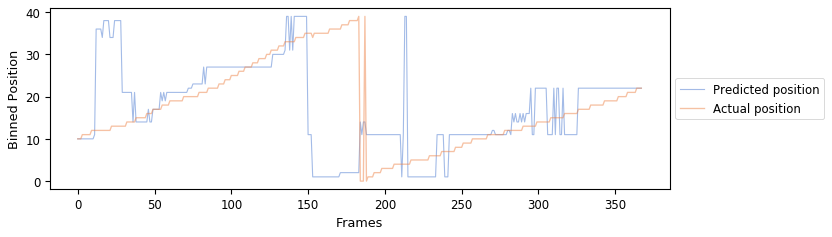

Validation 5
(1475, 304) (1475,) (368, 304) (368,)

Accuracy of test set:: 0.10%


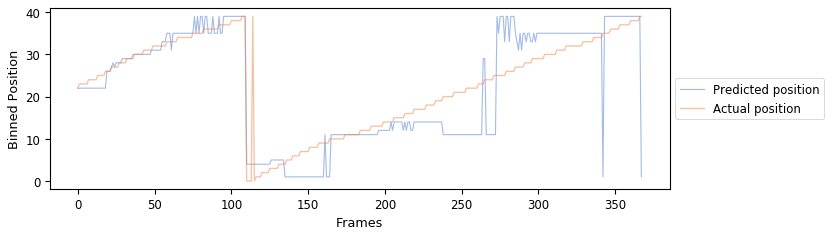

In [29]:
norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=1)

In [32]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['Animal'] = animalname

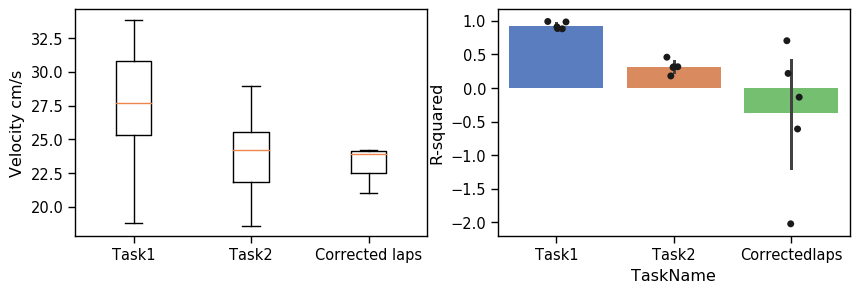

In [33]:
fs, ax1 = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');

### Decoding while lick is present

In [34]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[:stoplicklap]

Data shapes :  (924, 304) (924, 1)


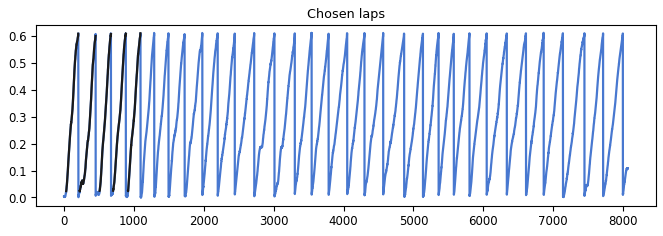

In [35]:
X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(stoplicklap), E_correction=1, lapcorrectionflag=1, figureflag=1)

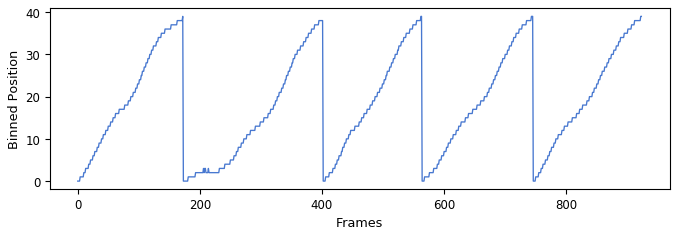

In [36]:
B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength, trackbins=trackbins)
y_v_new_lick_cat = B.position_binary

Data shapes :  (739, 304) (185, 304) (739,) (185,)

Accuracy of test set:: 0.35%


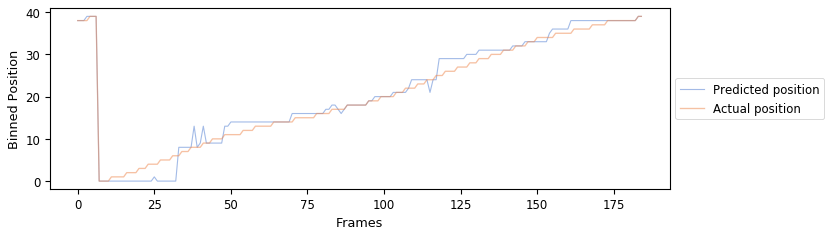

R2: 0.98
rho: 0.99




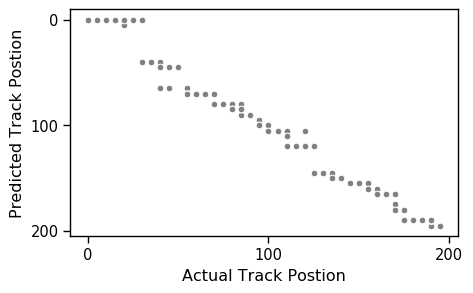

R2: 0.98
rho: 0.99




In [37]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_lick, y_v_new_lick_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(739, 304) (739,) (185, 304) (185,)

Accuracy of test set:: 0.10%


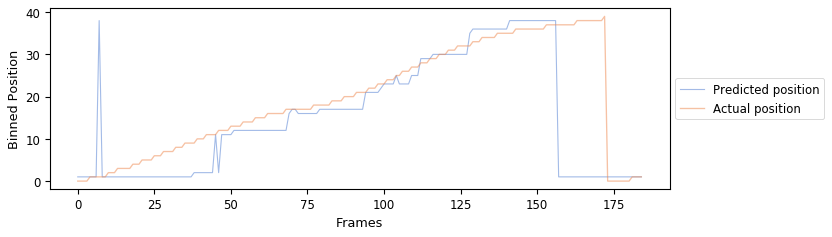

Validation 2
(739, 304) (739,) (185, 304) (185,)

Accuracy of test set:: 0.08%


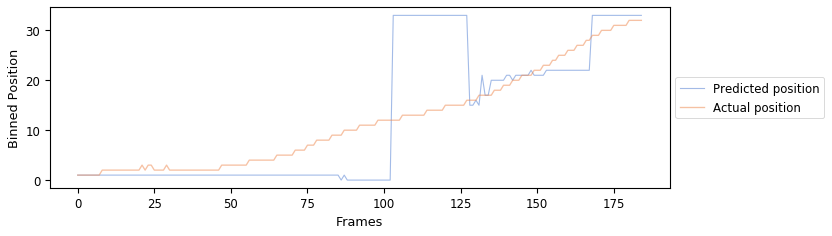

Validation 3
(739, 304) (739,) (185, 304) (185,)

Accuracy of test set:: 0.16%


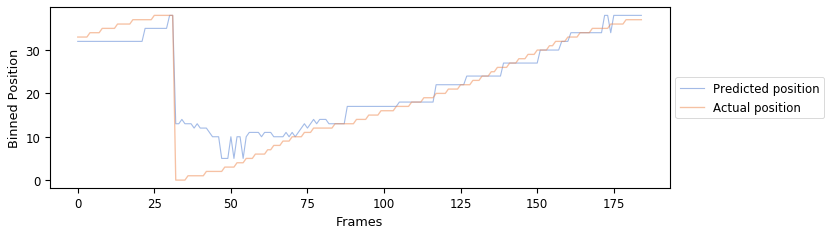

Validation 4
(739, 304) (739,) (185, 304) (185,)

Accuracy of test set:: 0.19%


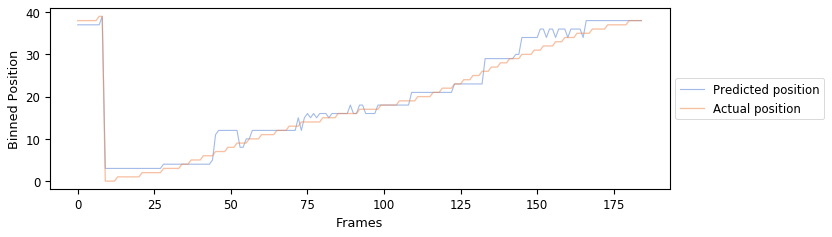

Validation 5
(740, 304) (740,) (184, 304) (184,)

Accuracy of test set:: 0.35%


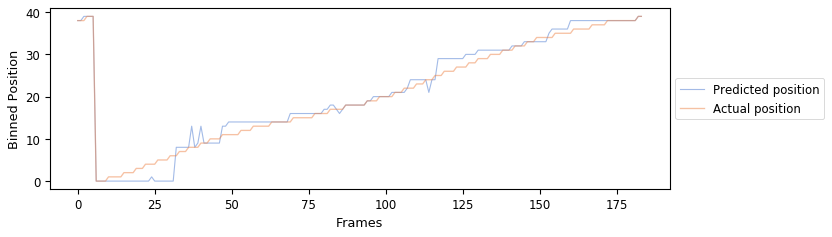

In [38]:
lickcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=1)

In [39]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2'], lickcv_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['TaskName'].iloc[nsplits*3:nsplits*4] = 'Task2_withlicks'
R2_dataframe['Animal'] = animalname

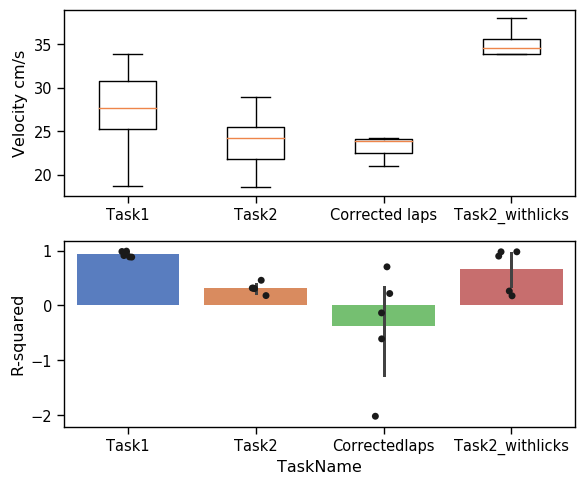

In [40]:
fs, ax1 = plt.subplots(2, 1, figsize=(6, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps, tracklength/laptime_lick], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps', 'Task2_withlicks'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save Results 

In [41]:
#Save R-squared dataframe
R2_dataframe.to_pickle(os.path.join(SaveResults, 'velocity_comparison_R2.pkl'))